# Home assignment (graded, individual, in 2 week)

### Peshkov Maksim

email to pandreyanov@gmail.com, use ipnb, use markdown, explain what you do

## download packages and data

In [1]:
import scipy as sp
import scipy.linalg as spla
import scipy.optimize as spopt
import scipy.stats as spst

from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,10)
from tqdm.notebook import tqdm

import numpy.linalg as npla

import statsmodels.api as sm
smfOLS = sm.regression.linear_model.OLS.from_formula

In [2]:
dat = sm.datasets.get_rdataset("Guerry", "HistData").data

In [3]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   dept             86 non-null     int64  
 1   Region           85 non-null     object 
 2   Department       86 non-null     object 
 3   Crime_pers       86 non-null     int64  
 4   Crime_prop       86 non-null     int64  
 5   Literacy         86 non-null     int64  
 6   Donations        86 non-null     int64  
 7   Infants          86 non-null     int64  
 8   Suicides         86 non-null     int64  
 9   MainCity         86 non-null     object 
 10  Wealth           86 non-null     int64  
 11  Commerce         86 non-null     int64  
 12  Clergy           86 non-null     int64  
 13  Crime_parents    86 non-null     int64  
 14  Infanticide      86 non-null     int64  
 15  Donation_clergy  86 non-null     int64  
 16  Lottery          86 non-null     int64  
 17  Desertion        8

## Assignment 1 (2 points).
Write a function assignment_1 that replicates the outcome of assignment_1_true on the *dat* dataset from the beginning of the notebook

In [4]:
def assignment_1_true(formula, data):
    
    fit = smfOLS(formula, data = data).fit()
    
    return fit.conf_int()

In [5]:
assignment_1_true('Lottery ~ Literacy + Donations + Infants + Wealth + Commerce', dat)

0          1
Intercept -6.027115  41.046645
Literacy  -0.479342   0.179528
Donations -0.000675   0.000954
Infants   -0.000005   0.001164
Wealth     0.096173   0.516922
Commerce  -0.100867   0.405366

In [6]:
def assignment_1(formula, data):
    ycolumn = formula.split(' ~ ')[0]
    xcolumns = formula.split(' ~ ')[1].split(' + ')
    Y = data[ycolumn].values
    X = data[xcolumns].values
    X = sm.add_constant(X)
    
    # my code
    beta = npla.solve(X.T@X, X.T@Y) #estimate beta

    e = Y-X@beta #estimate residuals

    sigma2 = (e.T@e)/(X.shape[0]-X.shape[1])

    cov = sigma2*npla.inv(X.T@X) #covariance matrix

    lower = beta - spst.t.ppf(1-0.025, X.shape[0]-X.shape[1])*np.sqrt(np.diag(cov)) #lower bondary
    upper = beta + spst.t.ppf(1-0.025, X.shape[0]-X.shape[1])*np.sqrt(np.diag(cov)) #upper bondary

    results = [[lower[i],upper[i]] for i in range(6)]

    df = pd.DataFrame(results, columns = [0,1])
    df.index = np.array(['Intercept'] + xcolumns)
    
    return df

### Check my function with true

In [7]:
assignment_1('Lottery ~ Literacy + Donations + Infants + Wealth + Commerce', dat)

0          1
Intercept -6.027115  41.046645
Literacy  -0.479342   0.179528
Donations -0.000675   0.000954
Infants   -0.000005   0.001164
Wealth     0.096173   0.516922
Commerce  -0.100867   0.405366

In [8]:
assignment_1_true('Lottery ~ Literacy + Donations + Infants + Wealth + Commerce', dat)

0          1
Intercept -6.027115  41.046645
Literacy  -0.479342   0.179528
Donations -0.000675   0.000954
Infants   -0.000005   0.001164
Wealth     0.096173   0.516922
Commerce  -0.100867   0.405366

## Assignment 2 (3 points).
- Write a function that finds the coefficients for the **elastic net** regularized ols with coefficients $\lambda$ and $\mu$ of your choice
- This time you do not need to find the standard errors

### Make loss function of Elastic Net

In [9]:
def loss_elastic_net(Y, X, beta, lamda, mu):
    z = Y - X@beta
    return z@z.T + lamda*(beta@beta.T) + mu*np.abs(beta).sum()

### Estimating function coefficients for Elastic Net

In [10]:
def assignment_2(formula, data, mu, lamda):
    ycolumn = formula.split(' ~ ')[0]
    xcolumns = formula.split(' ~ ')[1].split(' + ')
    Y = data[ycolumn].values
    X = data[xcolumns].values
    X = sm.add_constant(X)
    
    # my code
    
    covs = X.shape[1]
    bounds = [(None, None)]*covs
    results = spopt.shgo(lambda b: loss_elastic_net(Y, X, b, lamda, mu), bounds).x
    
    df = pd.DataFrame(results, columns = [0])
    df.index = np.array(['Intercept'] + xcolumns)
    
    return df

### Let's use $\lambda = 0.5$ and $\beta = 1$

In [11]:
assignment_2('Lottery ~ Literacy + Donations + Infants + Wealth + Commerce', dat, 0.5, 1)

0
Intercept  13.185481
Literacy   -0.098478
Donations   0.000150
Infants     0.000630
Wealth      0.310622
Commerce    0.174187

### Compare function results with $\lambda = 0$ and $\beta = 0$ with OLS coefficients

In [12]:
assignment_2('Lottery ~ Literacy + Donations + Infants + Wealth + Commerce', dat, 0, 0)

0
Intercept  17.510454
Literacy   -0.149910
Donations   0.000140
Infants     0.000579
Wealth      0.306553
Commerce    0.152254

In [13]:
#create X and Y for estimation
formula = 'Lottery ~ Literacy + Donations + Infants + Wealth + Commerce'
ycolumn = formula.split(' ~ ')[0]
xcolumns = formula.split(' ~ ')[1].split(' + ')
Y = dat[ycolumn].values
X = dat[xcolumns].values
X = sm.add_constant(X)

In [14]:
beta = npla.solve(X.T@X, X.T@Y)

df_ols = pd.DataFrame(beta, columns = [0])
df_ols.index = np.array(['Intercept'] + xcolumns)

df_ols

0
Intercept  17.509765
Literacy   -0.149907
Donations   0.000140
Infants     0.000579
Wealth      0.306547
Commerce    0.152250

**Because of error in optimized estimation in scipy we have a little diffirence, but coefficients are almost equal**

**But if use `scipy.optimize` and loss function for OLS regression, results are identical with my function when $\lambda = 0$ and $\beta = 0$**

In [15]:
def loss_OLS(Y, X, beta):
    z = Y - X@beta
    return z@z.T
covs = X.shape[1]
bounds = [(None, None)]*covs
results = spopt.shgo(lambda b: loss_OLS(Y, X, b), bounds).x
df_ols = pd.DataFrame(results, columns = [0])
df_ols.index = np.array(['Intercept'] + xcolumns)

df_ols

0
Intercept  17.510454
Literacy   -0.149910
Donations   0.000140
Infants     0.000579
Wealth      0.306553
Commerce    0.152254

## Assignment 3 (5 points)
- Write a function that finds the coefficients for the **elastic net** regularized ols with crossvalidation
- Use number of folds of your choice
- You do not need to find the standard errors
- Search for $\lambda$, $\mu$ in the range [0,5]x[0,5]

I use cross validation with metric SSR (proportional to $R^2$):
$$ SSR = e'e$$

### Function to estimate average SSR in folds

In [16]:
def run(lamda1,mu1, kf1, X, Y):
    avg = 0
    for train_index, test_index in kf1.split(X): #for each fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        #calculate beta
        covs = X_train.shape[1]
        bounds = [(None, None)]*covs
        beta = spopt.shgo(lambda b: loss_elastic_net(y_train, X_train, b, lamda1, mu1), bounds).x
        #calculate errors and SSR
        errors = X_test@beta - y_test
        SSR = errors@errors.T
        avg += SSR

    return avg/kf1.n_splits #average SSR

### Function to estimate optimal parametres

In [17]:
def assignment_3(formula, data, folds):
    
    kf = KFold(n_splits=folds)
    
    ycolumn = formula.split(' ~ ')[0]
    xcolumns = formula.split(' ~ ')[1].split(' + ')
    Y = data[ycolumn].values
    X = data[xcolumns].values
    X = sm.add_constant(X)
    
    lamda_mu_list = []
    for mu in tqdm(np.arange(0,5.05,0.05)): #loop for 101 values in [0,5]
        lamda_list = []
        for lamda in tqdm(np.arange(0,5.05,0.05),leave=False): #loop for 101 values in [0,5]
            lamda_list.append(run(lamda, mu, kf, X, Y))
        lamda_mu_list.append(lamda_list)
    
    #find index of minimum SSR
    ind_good = np.array(lamda_mu_list).reshape(-1).argmin()
    #find optimal parametres for optimal index
    mu_good = np.arange(0,5.05,0.05)[ind_good//101]
    lamda_good = np.arange(0,5.05,0.05)[ind_good%101]
    
    print('Index of minimum loss in list with losses:{:}'.format(ind_good))
    print('Optimal lambda: {:}, Optimal mu: {:}'.format(lamda_good,mu_good))
    
    #find beta coefficients with optimal parametres
    covs = X.shape[1]
    bounds = [(None, None)]*covs
    beta_good = spopt.shgo(lambda b: loss_elastic_net(Y, X, b, lamda_good, mu_good), bounds).x

    df = pd.DataFrame(beta_good, columns = [0])
    df.index = np.array(['Intercept'] + xcolumns)

    return df, np.array(lamda_mu_list) #return df with coefficients and list to draw graph of SSR

**Attention!!!**

Here you can spend a lot of time, because there are 3 loops in function $100\times100\times 5$ elements

...but I do not know how optimize in another way

In [18]:
d_elastic, list_par = assignment_3('Lottery ~ Literacy + Donations + Infants + Wealth + Commerce', dat, folds = 5)

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Index of minimum loss in list with losses:99
Optimal lambda: 4.95, Optimal mu: 0.0


In [19]:
d_elastic

0
Intercept  6.752719
Literacy  -0.021994
Donations  0.000165
Infants    0.000705
Wealth     0.316677
Commerce   0.206808

Optimal parametres are 0 and 4.95, because the optimize function of loss is strongly positive connected with $\mu$ $[0,5]$ and negative with $\lambda$ in $[0,5]$ 

(for $\lambda$ it is true before 4.95, after 4.95 is positive connection,which we can see in Ridge optimization and optimal parameter $\lambda$ is 4.95). 

These connections for $\mu$ and $\lambda$ you can see on graphs below $\downarrow$

### Plot SSR depending on parametres

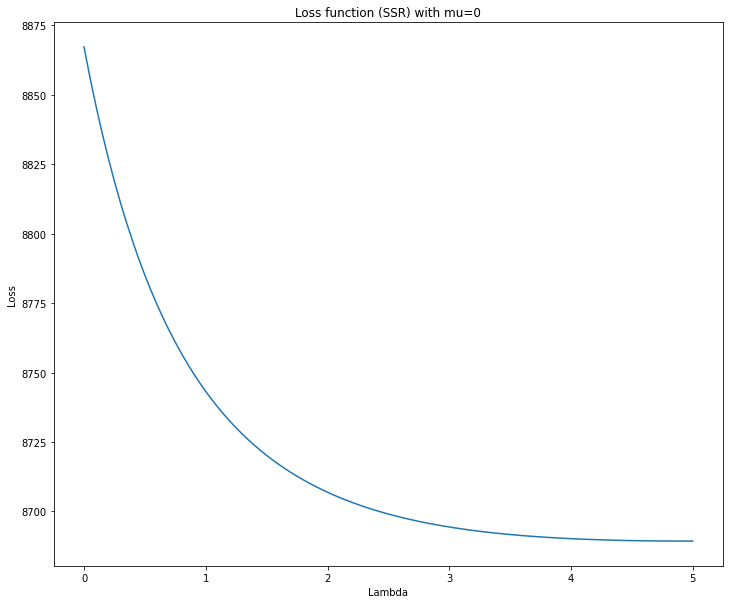

In [20]:
plt.plot(np.arange(0,5.05,0.05), list_par[0])
plt.title('Loss function (SSR) with mu=0')
plt.xlabel('Lambda')
plt.ylabel('Loss');

**Moreover, this graph is True for each value of mu, so $\lambda=4.95$ is optimal**

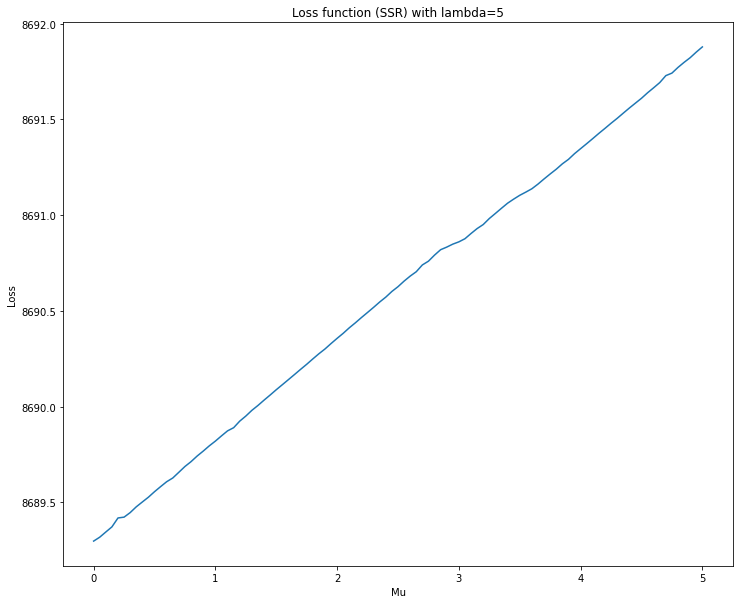

In [21]:
plt.plot(np.arange(0,5.05,0.05), [list_par[i][-2] for i in range(len(list_par))])
plt.title('Loss function (SSR) with lambda=5')
plt.xlabel('Mu')
plt.ylabel('Loss');

**So $\mu=0$ is optimal for optimal $\lambda=4.95$**

## Assignment 4 (5 points).
- Write a function that finds the coefficients for the **ridge** regularized ols with coefficient $\lambda$ crossvalidated
- This time you HAVE TO to find the standard errors
- Derive the standard errors in markdown, assuming homoskedasticity of errors $E[ee'|X]=\sigma^2 I$
- see, for example, https://lukesonnet.com/teaching/inference/200d_standard_errors.pdf
- also I've found here about Ridge https://arxiv.org/pdf/1509.09169.pdf

### Estimate the standard errors assuming homoskedasticity of errors

It is well-know how estimate $\beta$ coefficients of OLS and Ridge regressions

$$
\hat\beta_{OLS} = (X'X)^{-1}X'Y \\
\hat\beta_{Ridge} = (X'X+\lambda I)^{-1}X'Y$$

Moreover, from https://lukesonnet.com/teaching/inference/200d_standard_errors.pdf we know how estimate standard errors 
(especially variance) for OLS $\beta$ coefficients assuming homoskedasticity of errors
$$
V[\hat\beta_{OLS}|X] = \sigma^2 (X'X)^{-1} = \dfrac{e'e}{n-p} * (X'X)^{-1} $$

After that, we can express $\hat\beta_{Ridge}$ through $\hat\beta_{OLS}$ and estimate variance

$$\hat\beta_{Ridge} = (X'X+\lambda I)^{-1}X'Y= (X'X+\lambda I)^{-1} (X'X) (X'X)^{-1}X'Y  = (X'X+\lambda I)^{-1}(X'X)\hat\beta_{OLS} = W \hat\beta_{OLS} $$

Let W is a definite numerical matrix where

$$W = (X'X+\lambda I)^{-1}(X'X)$$

Estimate Variance, knowing that $Var(AB) = AVar(B)A'$, where A is a definite numerical matrix

$$V[\hat\beta_{Ridge}|X] = Var(W \hat\beta_{OLS}) = W Var(\hat\beta_{OLS}) W' = \{(X'X+\lambda I)^{-1}(X'X)\}\sigma^2 (X'X)^{-1} \{(X'X+\lambda I)^{-1}(X'X)\}' = $$
$$ = \sigma^2  (X'X+\lambda I)^{-1}(X'X) (X'X)^{-1} (X'X)[(X'X+\lambda I)^{-1}]'$$

$$V[\hat\beta_{Ridge}|X] = \sigma^2  (X'X+\lambda I)^{-1} (X'X)[(X'X+\lambda I)^{-1}]'$$

### Functions to estimate loss in Ridge regression and SSR

In [22]:
def loss_ridge(Y, X, beta, lamda):
    z = Y - X@beta
    return z@z.T + lamda*(beta@beta.T)

In [23]:
def run_ridge(lamda1, kf1, X, Y):
    avg = 0
    for train_index, test_index in kf1.split(X): #for each fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        #calculate beta
        covs = X_train.shape[1]
        bounds = [(None, None)]*covs
        beta = spopt.shgo(lambda b: loss_ridge(y_train, X_train, b, lamda1), bounds).x
        #calculate errors and SSR
        errors = X_test@beta - y_test
        SSR = errors@errors.T
        avg += SSR

    return avg/kf1.n_splits #average SSR

### Function that finds the coefficients for the ridge with coefficient  ùúÜ  crossvalidated

In [24]:
def assignment_4(formula, data, folds):
    
    kf = KFold(n_splits=folds)
    
    ycolumn = formula.split(' ~ ')[0]
    xcolumns = formula.split(' ~ ')[1].split(' + ')
    Y = data[ycolumn].values
    X = data[xcolumns].values
    X = sm.add_constant(X)
    
    lamda_list = []
    for lamda in tqdm(np.arange(0,100.02,0.02),leave=False): #loop for 101 values in [0,5]
        lamda_list.append(run_ridge(lamda, kf, X, Y))
    
    ind_good = np.array(lamda_list).argmin()

    lamda_good = np.arange(0,100.02,0.02)[ind_good]
    
    print('Optimal lambda: {:}'.format(lamda_good))
    
    #find beta coefficients with optimal parametres
    covs = X.shape[1]
    beta_good = npla.inv(X.T@X + lamda_good*np.ones(covs))@(X.T@Y)

    e = Y-X@beta_good

    sigma2 = (e.T@e)/(X.shape[0]-X.shape[1])

    cov = sigma2*npla.inv(X.T@X + lamda_good*np.ones(covs))@X.T@X@(npla.inv(X.T@X + lamda_good*np.ones(covs)).T)

    lower = beta_good - spst.t.ppf(1-0.025, X.shape[0]-X.shape[1])*np.sqrt(np.diag(cov)) 
    upper = beta_good + spst.t.ppf(1-0.025, X.shape[0]-X.shape[1])*np.sqrt(np.diag(cov))
    std = np.sqrt(np.diag(cov))

    df = pd.DataFrame(beta_good, columns = ['Ridge_coef'])
    df.index = np.array(['Intercept'] + xcolumns)
    
    df['std_Ridge'] = std
    df['lower_bound_ci'] = lower
    df['upper_bound_ci'] = upper

    return df, np.array(lamda_list) #return df with coefficients and list to draw graph of SSR

In [25]:
d_ridge, list_par_ridge = assignment_4('Lottery ~ Literacy + Donations + Infants + Wealth + Commerce', dat, folds = 5)
d_ridge

  0%|          | 0/5001 [00:00<?, ?it/s]

Optimal lambda: 4.92


Ridge_coef  std_Ridge  lower_bound_ci  upper_bound_ci
Intercept    6.544967   4.705779       -2.819832       15.909765
Literacy    -0.020081   0.104791       -0.228621        0.188460
Donations    0.000167   0.000411       -0.000650        0.000984
Infants      0.000709   0.000265        0.000182        0.001237
Wealth       0.316689   0.105798        0.106145        0.527234
Commerce     0.207182   0.115578       -0.022826        0.437190

### Graph with SSR

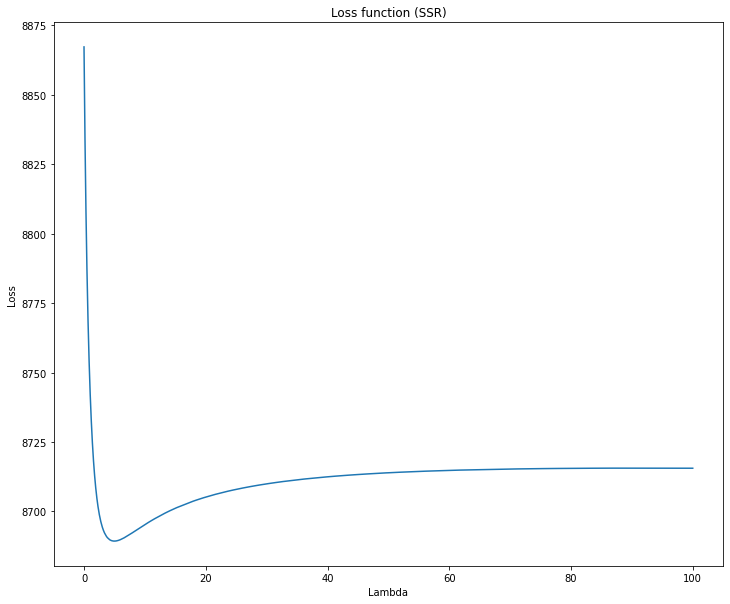

In [26]:
plt.plot(np.arange(0,100.02,0.02), list_par_ridge)
plt.title('Loss function (SSR)')
plt.xlabel('Lambda')
plt.ylabel('Loss');

### Compare Ridge and OLS

In [27]:
beta = npla.solve(X.T@X, X.T@Y) #estimate beta
e = Y-X@beta #estimate residuals
sigma2 = (e.T@e)/(X.shape[0]-X.shape[1])
cov = sigma2*npla.inv(X.T@X)
std = np.sqrt(np.diag(cov))
df_ols = pd.DataFrame(beta, columns = ['OLS_coef'])
df_ols.index = np.array(['Intercept'] + xcolumns)
df_ols['std_OLS'] = std
df_ols

OLS_coef    std_OLS
Intercept  17.509765  11.827201
Literacy   -0.149907   0.165540
Donations   0.000140   0.000409
Infants     0.000579   0.000294
Wealth      0.306547   0.105712
Commerce    0.152250   0.127190

In [28]:
d_ridge[['Ridge_coef', 'std_Ridge']]

Ridge_coef  std_Ridge
Intercept    6.544967   4.705779
Literacy    -0.020081   0.104791
Donations    0.000167   0.000411
Infants      0.000709   0.000265
Wealth       0.316689   0.105798
Commerce     0.207182   0.115578

* Standard errors for *intercept and Literacy* are less in Ridge, while standard errors are particularly the same for others

* Coefficients in Ridge regression are also less for intercept and Literacy

Both these facts demonstrate the regularization of Ridge Regression